In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import required libraries
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt

from plotutils import plot_data, plot_surface
from Multiclass_SVM import fit, predict
from confusion_matrix import make_confusion_matrix
from crossval import cross_validate

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from skimage.feature import hog

In [3]:
# Read the data using pandas
df = pd.read_csv('digit-recognition/digit-recognition/train.csv')
df2 = pd.read_csv('digit-recognition/digit-recognition/test.csv')

#turn the training dataframe into numpy array 
label_data_train = df.to_numpy()

#column vector for the labels (38000,)
label_train = label_data_train[:,0] 

# (38000 x 784 matrix for the training data )
data_train = label_data_train[:, 1:] 

# Turn testing dataframe into numpy array 
label_data_test = df2.to_numpy()
label_test = label_data_test[:,0]
data_test = label_data_test[:,1:]

list_hog = []
list_hog1 = []
for feature in data_train:
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(4,4),cells_per_block=(3,3),visualize=False ) #can probably optimize this
    list_hog.append(fd) #4x4 seems to be optimal 
hog_features_train = np.array(list_hog, 'float64')

#on testing data 
for feature in data_test:
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(4,4),cells_per_block=(3,3),visualize=False )
    list_hog1.append(fd)
hog_features_test = np.array(list_hog1, 'float64')
data_train = hog_features_train
data_test = hog_features_test

In [4]:
# Determine our dataset size for cross validation and training
num_cv_splits = 50
num_train_splits = 5 #int(num_cv_splits/2)

# Initialize variables here for convenient use throughout
num_labels = len(np.unique(label_train))
c_vals = 10 ** np.linspace(-2, 1, 4)
orders = [5, 6, 7, 8, 9, 10]
num_folds = 2
kernels = ['polynomial', 'linear']

CV Subset selection: 5


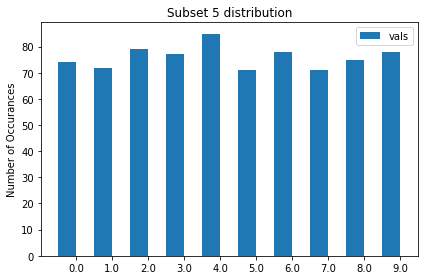

In [5]:
# We won't cross validation on the whole data set to save time. 
# Pick our subset by choosing the split with the most equal label distribution.
frequencies = np.zeros((num_cv_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_cv_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
cv_subset_selection = np.argmin(variances)
print("CV Subset selection: {0}".format(cv_subset_selection))

labels = frequencies[cv_subset_selection][:, 0]
vals = frequencies[cv_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(cv_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Training subset selection: 2


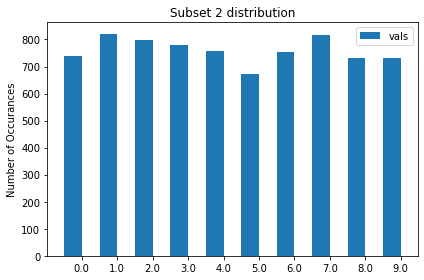

In [6]:
# We won't train on the whole data set either but will get a data subset larger than the CV subset. 
# Pick our subset by choosing the split with the most equal label distribution.
frequencies = np.zeros((num_train_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_train_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
training_subset_selection = np.argmin(variances)
print("Training subset selection: {0}".format(training_subset_selection))

labels = frequencies[training_subset_selection][:, 0]
vals = frequencies[training_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(training_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [7]:
#Split the data set based on the subset selections above 
split_cv_data = np.split(data_train, num_cv_splits)[cv_subset_selection]
split_cv_labels = np.split(label_train, num_cv_splits)[cv_subset_selection]

split_train_data = np.split(data_train, num_train_splits)[training_subset_selection]
split_train_labels = np.split(label_train, num_train_splits)[training_subset_selection]

Determined best SVM parameters: {'kernel': 'polynomial', 'C': 0.01, 'order': 8}


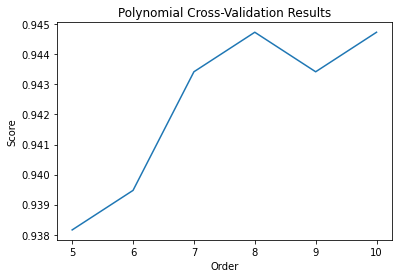

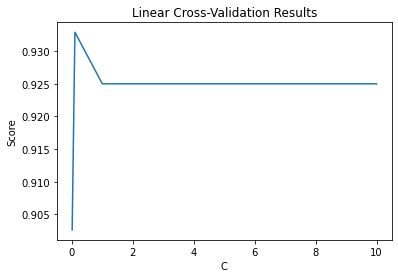

In [8]:
# Run cross validation on both kernels to determine best parameters
best_params = []
best_score = 0
poly_scores = np.zeros((len(c_vals), len(orders)))
lin_scores = []
times_append =0 

for j in range(len(c_vals)):
    params = {
        'kernel': 'linear',
        'C': c_vals[j],
    }

    cv_score, _ = cross_validate(fit, predict, split_cv_data, split_cv_labels, num_folds, params)
    lin_scores.append(cv_score)
    if cv_score > best_score:
        best_score = cv_score
        best_params = params
                
for j in range(len(c_vals)):
    for k in range(len(orders)):
        params = {
            'kernel': 'polynomial',
            'C': c_vals[j],
            'order': orders[k]
        }

        cv_score, _ = cross_validate(fit, predict, split_cv_data, split_cv_labels, num_folds, params)
        poly_scores[j][k] = cv_score
        if cv_score > best_score:
            best_score = cv_score
            best_params = params
        
max_orders = np.max(poly_scores, axis=0)
plt.plot(orders, max_orders, label='Polynomial')
plt.xlabel("Order")
plt.ylabel("Score")
plt.title("Polynomial Cross-Validation Results")
plt.figure()

plt.plot(c_vals, lin_scores, label='Linear')
plt.xlabel("C")
plt.ylabel("Score")
plt.title("Linear Cross-Validation Results")

print("Determined best SVM parameters: {0}".format(best_params))

In [10]:
# Run SVM with the selected parameters
start = time.time()

model = fit(split_train_data, split_train_labels, best_params, True)
train_predictions = predict(split_train_data.T, model)
predictions = predict(data_test.T, model)

end = time.time()
print("Took " + str(round(end - start, 2)) + " seconds to fit models and predict results")

train_accuracy = np.mean(train_predictions == split_train_labels)
test_accuracy = np.mean(predictions == label_test)

print("Train accuracy: {0} %".format(train_accuracy*100))
print("Test accuracy: {0} %".format(test_accuracy*100))

Finished fitting binary model 0
Finished fitting binary model 1
Finished fitting binary model 2
Finished fitting binary model 3
Finished fitting binary model 4
Finished fitting binary model 5
Finished fitting binary model 6
Finished fitting binary model 7
Finished fitting binary model 8
Finished fitting binary model 9
Took 18348.1 seconds to fit models and predict results
Train accuracy: 100.0 %
Test accuracy: 98.425 %


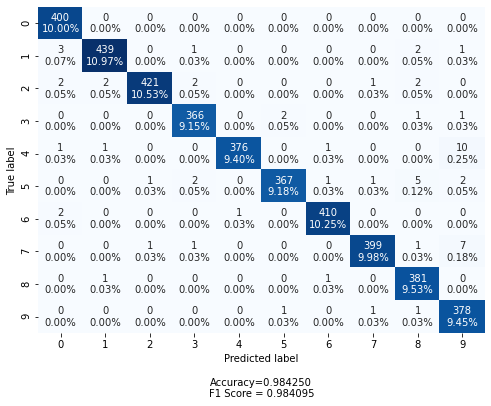

In [11]:
#Confusion Matrix using scikit-learn and seaborn
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = confusion_matrix(label_test, predictions)
make_confusion_matrix(cf_matrix, label_test, predictions, figsize=(8,6), cbar=False)

In [12]:
#F-score computation of the f1_score using sci-kit learn 
p_score = precision_score(label_test, predictions, average='macro')
macro_f1_score = f1_score(label_test, predictions, average='macro')

print("Precision Score: {0}".format(round(p_score * 100, 3)))
print("F1 Score - Macro Average: {0}".format(round(macro_f1_score * 100, 3)))

Precision Score: 98.419
F1 Score - Macro Average: 98.409


In [13]:
#Let's compare to sklearn's multiclass SVM implementation to check our accuracy
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(SVC()).fit(split_train_data, split_train_labels)
sklearn_predictions = clf.predict(data_test)
sklearn_test_accuracy = np.mean(sklearn_predictions == label_test)
print("SKL Test accuracy: {0} %".format(sklearn_test_accuracy*100))

Test accuracy: 98.32499999999999 %
